## Use feature-weighted rf model on the crcns vim-1 dataset

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from theano import tensor as tnsr
from theano import function, scan
from time import time
from scipy.signal import convolve2d as conv2d
from hrf_fitting.src.features import make_gaussian, construct_placement_grid
from glob import glob
from scipy.io import loadmat
from hrf_fitting.src.feature_weighted_rf_models import apply_rf_to_feature_maps, bigmult, compute_grad,sq_diff_func
from hrf_fitting.src.features import make_complex_gabor as gaborme
from PIL import Image



Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 760


### Step 1: construct feature maps

In [2]:
Df, Do = 8, 8  #Df = sp. freq. divisions, Do = orientations
D = Df*Do + 1  # +1 for a bias dimension

#### load crcns stimuli

In [3]:
stim_location = '/media/tnaselar/Data/crcns_datasets/vim-1/Stimuli.mat'
crcns_stim_dict = loadmat(stim_location)

In [4]:
##need 'stimVal' and 'stimTrn'
print crcns_stim_dict['stimVal'].shape
print crcns_stim_dict['stimTrn'].shape

(120, 128, 128)
(1750, 128, 128)


In [5]:
##remember stim params
Ttrn = crcns_stim_dict['stimTrn'].shape[0]
Tval = crcns_stim_dict['stimVal'].shape[0]
T = Ttrn+Tval
native_stim_size = crcns_stim_dict['stimTrn'].shape[1]
n_image_channels = 1 ##could be 3 for color images.
stim_size = 32


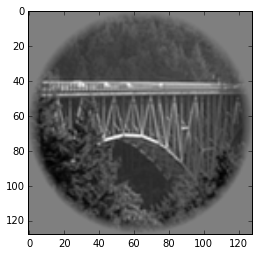

In [6]:
plt.imshow(crcns_stim_dict['stimVal'][0,:,:],cmap='gray')

#### construct gabor wavelet stack

In [7]:
##parameters for designing gabor feature maps
##specify frequencies in cycles_per_pixel, use to determine size of prf.
##should probably specify in cycles per deg.

pixel_per_deg = 25*(stim_size/500.)    ##determined by experiment 34.751 = match/nonmatch exp.
pixels_per_stimulus = stim_size ##det. by exp. 768 = match/nonmatch exp.
cycles_per_deg = .05*np.logspace(0,1.7,num=Df)
cycles_per_pixel = cycles_per_deg/pixel_per_deg  ##cyc/pix
cycles_per_fwhm = 2.0
fwhms_per_kernel = 2.0 ##determines how big the picture of the gabor will be.

metrics = {'cycles per pixel':cycles_per_pixel,
           'pixels per cycle': 1./cycles_per_pixel,
           'cycles per stimulus': cycles_per_pixel*pixels_per_stimulus,
           'cycles per deg.': cycles_per_deg,
           'fwhm (pix)': np.clip(cycles_per_fwhm/cycles_per_pixel,0,pixels_per_stimulus),
           'prf_size (deg)': np.clip(cycles_per_fwhm/cycles_per_pixel,0,pixels_per_stimulus)/pixel_per_deg/2.,
           'n_pix': np.clip(fwhms_per_kernel*cycles_per_fwhm/cycles_per_pixel,0,pixels_per_stimulus)}

fm = pd.DataFrame(metrics)
fm

,cycles per deg.,cycles per pixel,cycles per stimulus,fwhm (pix),n_pix,pixels per cycle,prf_size (deg)
0,0.050000,0.031250,1.000000,32.000000,32.000000,32.000000,10.000000
1,0.087464,0.054665,1.749271,32.000000,32.000000,18.293333,10.000000
2,0.152997,0.095623,3.059950,20.915377,32.000000,10.457688,6.536055
3,0.267634,0.167271,5.352682,11.956623,23.913247,5.978312,3.736445
4,0.468165,0.292603,9.363292,6.835203,13.670406,3.417601,2.136001
5,0.818947,0.511842,16.378937,3.907457,7.814915,1.953729,1.221080
6,1.432560,0.895350,28.651203,2.233763,4.467526,1.116882,0.698051
7,2.505936,1.566210,50.118723,1.276968,2.553936,0.638484,0.399052


In [8]:
oris = np.linspace(0, 2*np.pi, num=Do, endpoint=False)

(65, 2, 32, 32)


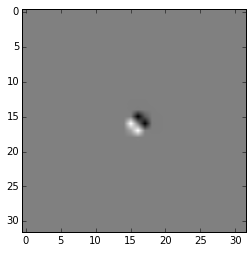

In [9]:
##create filter stack, but separate real/imag parts because theano doesn't like complex numbers
##here we leave Dth filter at zero because later we will add a "bias" feature of all 1's.
filter_channels = 2
filter_stack = np.zeros((D, filter_channels, stim_size, stim_size)).astype('float32')
f_counter = 0
for df in range(Df):
    for do in range(Do):
        ori = oris[do]
        center = (0,0)
        freq = fm.loc[df,'cycles per stimulus']
        fwhm = fm.loc[df,'fwhm (pix)']
        n_pix = stim_size
        tmp_filter = gaborme(freq,ori,center,fwhm,n_pix)
        filter_stack[f_counter,0,:,:] = np.real(tmp_filter).astype('float32')
        filter_stack[f_counter,1,:,:] = np.imag(tmp_filter).astype('float32')
        f_counter += 1
##show imag. part of some filter    
plt.imshow(filter_stack[-2,1,:,:],cmap='gray')
print filter_stack.shape


#### generate feature maps

In [10]:
##--make a theano function for this
stim_tnsr = tnsr.tensor4('stim_tnsr')  ##T x n_image_channels x stim_size x stim_size
real_filter_stack_tnsr = tnsr.tensor4('real_feature_map_tnsr') ##D x n_image_channels x stim_size x stim_size. complex
imag_filter_stack_tnsr = tnsr.tensor4('imag_feature_map_tnsr') ##D x n_image_channels x stim_size x stim_size. complex
filter_stack_tnsr_shape = (1, n_image_channels,stim_size,stim_size)
real_feature_map_tnsr = tnsr.nnet.conv2d(stim_tnsr,
                                 real_filter_stack_tnsr,
                                 image_shape = (1,n_image_channels,stim_size,stim_size),
                                 filter_shape = filter_stack_tnsr_shape,
                                 border_mode = 'full')  ##produces T x D x stim_size x stim_size maps
imag_feature_map_tnsr = tnsr.nnet.conv2d(stim_tnsr,
                                 imag_filter_stack_tnsr,
                                 image_shape = (1,n_image_channels,stim_size,stim_size),
                                 filter_shape = filter_stack_tnsr_shape,
                                 border_mode = 'full')  ##produces T x D x stim_size x stim_size maps

##for filtering with complex gabors, we need an operation for squaring/summing real/imag parts

abs_value = tnsr.sqrt(tnsr.sqr(real_feature_map_tnsr) + tnsr.sqr(imag_feature_map_tnsr))
##functionize feature mapping
make_feature_maps = function(inputs = [stim_tnsr,real_filter_stack_tnsr,imag_filter_stack_tnsr],
                             outputs = abs_value)

In [11]:
feature_maps = np.zeros((T,D,stim_size,stim_size))
stimuli = np.concatenate((crcns_stim_dict['stimVal'],crcns_stim_dict['stimTrn']),axis=0)
for d in range(Df*Do):
    start = time()
    for t in range(T):
        this_stim = np.array(Image.fromarray(stimuli[t,:,:]).resize((stim_size,stim_size))).astype('float32')
        this_stim = this_stim[np.newaxis,np.newaxis,:,:]
        tmp_feature_map = make_feature_maps(this_stim,
                                            np.reshape(filter_stack[d,0,:,:], (1,n_image_channels,stim_size,stim_size)),
                                            np.reshape(filter_stack[d,1,:,:], (1,n_image_channels,stim_size,stim_size)))
    
        ##crop because convolution
        new_size = tmp_feature_map.shape[2]
        crop_start = np.round((new_size-stim_size)/2.).astype('int')
        crop_stop = crop_start+stim_size
        feature_maps[t,d,:,:] = tmp_feature_map[:, :, crop_start:crop_stop, crop_start:crop_stop]
    print 'feature %d took %0.3f' %(d,time()-start)
print feature_maps.shape


feature 0 took 3.878
feature 1 took 3.851
feature 2 took 3.794
feature 3 took 3.817
feature 4 took 3.758
feature 5 took 3.693
feature 6 took 3.706
feature 7 took 3.749
feature 8 took 3.753
feature 9 took 3.702
feature 10 took 3.738
feature 11 took 3.759
feature 12 took 3.852
feature 13 took 3.781
feature 14 took 3.684
feature 15 took 3.694
feature 16 took 3.708
feature 17 took 3.723
feature 18 took 3.707
feature 19 took 3.730
feature 20 took 3.731
feature 21 took 3.707
feature 22 took 3.748
feature 23 took 3.737
feature 24 took 3.731
feature 25 took 3.750
feature 26 took 3.670
feature 27 took 3.651
feature 28 took 3.662
feature 29 took 3.640
feature 30 took 3.640
feature 31 took 3.648
feature 32 took 3.683
feature 33 took 3.689
feature 34 took 3.662
feature 35 took 3.744
feature 36 took 3.698
feature 37 took 4.259
feature 38 took 3.721
feature 39 took 4.552
feature 40 took 3.781
feature 41 took 3.708
feature 42 took 3.711
feature 43 took 3.744
feature 44 took 3.751
feature 45 took 3.76

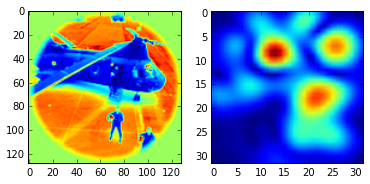

In [12]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(stimuli[-1,:,:])
plt.subplot(1,2,2)
plt.imshow(feature_maps[-1,32,:,:])

In [13]:
##force float 32 explicitly
feature_maps = feature_maps.astype('float32')

### Step 2: construct model_space

#### create receptive field model stack

In [14]:
Gx,Gy,Gw = 4,4,Df
G = Gx*Gy*Gw

In [15]:
def space_time_kernel(center, fwhm, n_pix, time_kernel):
    '''
    a separable space-time kernel.
    space kernel is gaussian
    time kernel is an array of length T
    returns a 3-D volume that is (n_pix,n_pix,T)
    slice it to see what it does.
    '''
    space_kernel = np.atleast_3d(make_gaussian(center,fwhm,n_pix))
    return time_kernel*space_kernel
    

In [16]:
##dumb grid
##create filter stack, but separate real/imag parts because theano doesn't like complex numbers
g_counter = 0
half_stim_size = np.round(stim_size/2.).astype('int')
g_rows, g_cols = construct_placement_grid([-half_stim_size,half_stim_size,-half_stim_size,half_stim_size],np.round(stim_size/Gx).astype('int'))
rf_stack = np.zeros((Gx*Gy*Gw, stim_size, stim_size)).astype('float32')
for gw in fm['fwhm (pix)']:
    for gx,gy in zip(g_rows.ravel(),g_cols.ravel()):
            center = (gx,gy)
            fwhm = gw
            rf_stack[g_counter,:,:] = np.squeeze(space_time_kernel(center, fwhm, stim_size, 1)).astype('float32')
            g_counter += 1

(128, 32, 32)


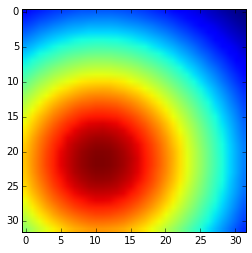

In [17]:
plt.imshow(rf_stack[17+8,:,:])
print rf_stack.shape

#### apply rf stack to feature maps to construct model_space

In [18]:
model_space = np.zeros((G,T,D))
for t in range(T):
    start = time()
    model_space[:,np.newaxis,t,:] = apply_rf_to_feature_maps(rf_stack, feature_maps[t,np.newaxis,:,:])
    if (t % 100) == 0:
        print time()-start

0.0118110179901
0.00098705291748
0.00125408172607
0.00116991996765
0.00100994110107
0.00102710723877
0.000994920730591
0.00101804733276
0.000996828079224
0.00100708007812
0.00123286247253
0.0010199546814
0.00106120109558
0.000992059707642
0.00112080574036
0.00100183486938
0.00100898742676
0.0010449886322
0.00100183486938


In [19]:
#### normalize model space and add a column of 1's to each model
model_space = model_space - np.expand_dims(np.mean(model_space,axis=1),axis=1)
model_space = model_space / np.expand_dims(np.std(model_space,axis=1),axis=1)
model_space[:,:,-1] = 1


In [20]:
##clear up some memory
#feature_maps = []

In [21]:
model_space = model_space.astype('float32')

### Step 3: train model on real data

#### load voxel data

In [22]:
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file)
crcns_voxel_data.keys()

[u'dataTrnS1',
 u'dataTrnS2',
 u'dataValS1',
 u'dataValS2',
 u'roiS1',
 u'roiS2',
 u'voxIdxS1',
 u'voxIdxS2']

In [23]:
Vs1 = crcns_voxel_data['dataTrnS1'].shape[1]
print Vs1

25915


In [91]:
voxel_data = np.concatenate((crcns_voxel_data['dataValS1'],crcns_voxel_data['dataTrnS1']),axis=0).astype('float32')
no_nan = np.isnan(crcns_voxel_data['dataTrnS1']).sum(axis=0) == 0
voxel_data = voxel_data[:,no_nan]
print voxel_data.shape
V = voxel_data.shape[1]

(1870, 22733)


#### training / testing splits

In [ ]:
feature_maps = []

In [111]:
trnIdx = np.arange(Tval,T)
valIdx = np.arange(0,Tval)
early_stop_fraction = 0.6
early_stop_num = np.round(len(trnIdx)*early_stop_fraction).astype('int')
training_rounds = 4
voxel_binsize = 300.
voxel_bin_num = np.round(V/voxel_binsize)
voxel_bins = np.linspace(0,V-1,num=voxel_bin_num,endpoint=True)
max_iters = 100
learning_rate = 10**(-5)

In [113]:
for rounds in range(training_rounds):
    perm_dx = np.random.permutation(trnIdx)
    validation_idx = perm_dx[0:early_stop_num]
    training_idx = perm_dx[early_stop_num:]
    validation_idx = np.atleast_2d(np.sort(validation_idx).astype('int')).T
    training_idx = np.atleast_2d(np.sort(training_idx).astype('int')).T
    
    for v in range(len(voxel_bins)-1):
        ##initialize feature weights
        v_idx = np.atleast_2d(np.arange(voxel_bins[v], voxel_bins[v+1]).astype('int'))
        feature_weights = np.random.rand(G, D, v_idx.shape[1]).astype('float32')
        #best_params = None
        iters = 0
        this_validation_loss = Inf
        best_validation_loss = Inf
        iter_error = np.zeros((max_iters,v_idx.shape[1]))
        bestie_change = np.zeros(max_iters)
        start = time()
        old_besties = np.zeros(v_idx.shape[1])
        print '--------------new voxels--------------'
        while (iters < max_iters):
            best_validation_loss = this_validation_loss


            ##gradient
            d_loss_wrt_params = compute_grad(voxel_data[training_idx, v_idx],
                                        model_space[:,training_idx.flatten(),:],
                                        feature_weights)  
            ##update
            feature_weights -= learning_rate * d_loss_wrt_params


            ##---check effect of gradient step

            ##predictions with updated params
            prediction_menu = bigmult(model_space[:,validation_idx.flatten(),:],
                                      feature_weights)

            ##update loss
            this_validation_loss = sq_diff_func(voxel_data[validation_idx, v_idx],
                                                prediction_menu)

            ##keep track / report
            iter_error[iters,:]  = np.min(this_validation_loss,axis=0)
            besties = np.argmin(this_validation_loss,axis=0)
            bestie_change[iters] = np.sum(besties - old_besties)
            old_besties = copy(besties)
            if iters % 10 == 0:
                print '-------'
                print 'errors: %f' %(np.nanmean(iter_error[iters,:]))
                print 'change in best rf: %f' %(bestie_change[iters])
                print time()-start
                start = time()
                

            iters += 1
                                   

--------------new voxels--------------
-------
errors: 100685.214381
change in best rf: 28248.000000
0.344388008118
-------
errors: 2678.651176
change in best rf: -102.000000
3.44092679024
-------
errors: 1726.284450
change in best rf: 790.000000
3.29718494415
-------
errors: 1496.710909
change in best rf: 486.000000
3.27948689461
-------
errors: 1371.600268
change in best rf: 507.000000
3.27615404129
-------
errors: 1291.982808
change in best rf: 67.000000
3.28771495819
-------
errors: 1237.695292
change in best rf: 202.000000
3.28858995438
-------
errors: 1198.616137
change in best rf: 35.000000
3.30708909035
-------
errors: 1169.946105
change in best rf: 0.000000
3.32906603813
-------
errors: 1148.515328
change in best rf: 253.000000
3.32376790047
--------------new voxels--------------
-------
errors: 100652.108244
change in best rf: 28794.000000
0.326285839081
-------
errors: 2685.212498
change in best rf: -640.000000
3.29484987259
-------
errors: 1735.450528
change in best rf: 833

KeyboardInterrupt: 

In [114]:
10*3.4*(25000/300.)/60./60.

0.7870370370370369

In [115]:
25000/300.

83.33333333333333

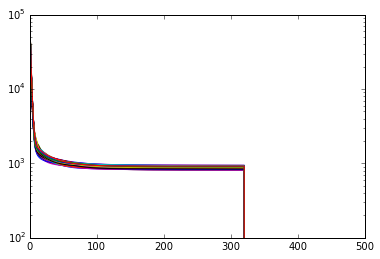

In [100]:
plt.plot(iter_error)
gca().set_yscale('log')

#### average parameters across training loops

### Step 4:  validation and model analysis